# Работа с корпусом

### Содержание тетрадки:
1. создание датафрейма с текстами из файлов на устройстве
2. приведение текстов к виду, который позволяет работать с ним дальше (удаление всего текста, который не является разговорным/песенным, т.е. не должен учитываться: названия песен, технические пометки и проч.)
3. предобработка: нормализация, токенизация, лемматизация -> создание разных вариантов результата, которые нужны нам для разных задач
- - -
4. взгляд на весь корпус в целом: топ-100 самых частотных лемм, отрисовка графика частот с примерно выполняющимся законом Ципфа
5. TF-IDF
6. Косинусная близость текстов либретто. Визуализация в виде матрицы
- - -
7. Оценка лексического разнообразия: TTR и Moving Average TTR (общий + динамика изменения MA TTR по мере продвижения тексту). Визуализация - графики
8. Статистика по частям речи (зачем она была подсчитана, вспомнить уже сложно)


In [ ]:
import re
import os # работа с файлами
import pandas as pd
import numpy as np

from tqdm import tqdm # прогрессбар на всякий

In [ ]:
# предобработка
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize

# стоп-слова
from nltk.corpus import stopwords
nltk_stopwords_ru = stopwords.words('russian')


In [ ]:
import sklearn

## Создание корпуса из файлов

In [ ]:
os.getcwd()

'c:\\Users\\User\\Desktop\\КЛ\\Проект'

In [ ]:
os.chdir('C:/Users/User/Desktop/КЛ/либретто/Берем/Готово к работе')

In [ ]:
filenames = os.listdir()
print(filenames)
print('Количество файлов с либретто:', len(filenames))

['aisvill_fin.txt', 'bal_vampirov_spb_fin.txt', 'cats_ru.txt', 'chess_ru_fin.txt', 'circus_princess_fin.txt', 'eloya_fin.txt', 'hairs_ru_fin_edited.txt', 'jane_eyre_fin.txt', 'jesus_mossovet.txt', 'karenina_fin.txt', 'mammamia_ru_fin.txt', 'master_and_margarita.txt', 'maugli_illusion_fin.txt', 'mertvye_dushi_fin.txt', 'metro(rus)_fin.txt', 'monte_cristo_fin.txt', 'nddp_fin.txt', 'nordost_fin.txt', 'ostrov_fin.txt', 'petya_i_folk_fin.txt', 'pin_fin.txt', 'PrimeTime_fin.txt', 'pyotr_fin.txt', 'romeoandjuliet_ru_fin.txt', 'romeo_vs_juliet_fin.txt', 'son_fin.txt', 'viy_fin.txt', 'vozdukh_fin.txt', 'Vseozolushke_fin.txt', 'Белый. Петербург. Полное либретто_fin.txt']
Количество файлов с либретто: 30


In [ ]:
texts = []
for i in filenames:
    with open(f'{str(os.getcwd())}/{i}', encoding = 'utf-8') as file:
        text = file.read()
        title = re.search(r'(?<=---\n).+\n', text).group().strip() # каждый файл имеет шапку, где первая строка - название спектакля
        texts.append((title, text))

In [ ]:
df_texts = pd.DataFrame(texts, columns = ['Название', 'Текст'])
df_texts

Название  \
0                               Айсвилль   
1                           Бал Вампиров   
2                                  Кошки   
3                                Шахматы   
4                        Принцесса цирка   
5                                   Элоя   
6                                 Волосы   
7                              Джейн Эйр   
8   Иисус Христос Суперзвезда (Моссовет)   
9                          Анна Каренина   
10                            MAMMA MIA!   
11                    Мастер и Маргарита   
12                                Маугли   
13                          Мёртвые души   
14                                 Метро   
15                          Монте-Кристо   
16                      Нотр-Дам де Пари   
17                              Норд-Ост   
18                       Остров сокровищ   
19                           ПЕТЯ И ФОЛК   
20              Преступление и наказание   
21                             Праймтайм   
22                           ПËТР ПЕРВЫЙ   
23                     Ромео и Джульетта   
24    РОМЕО VS. ДЖУЛЬЕТТА: XX ЛЕТ СПУСТЯ   
25                    Сон у Красной горы   
26                                   Вий   
27                           Воздух 2112   
28                         Всё о Золушке   
29                      Белый. Петербург   

                                                Текст  
0   ---\nАйсвилль\nТеатр на Садовой \n\n(Приют ком...  
1   ---\nБал Вампиров\nСанкт-Петербургский театр м...  
2   ---\nКошки\nCats\nПеревод: Алексей Кортнев\n--...  
3   ---\nШахматы\nПеревод: Алексей Иващенко\n---\n...  
4   ---\nПринцесса цирка\nМосковский театр мюзикла...  
5   ---\nЭлоя\nСтихи: Анна Махнева\n---\n\n\n1. УВ...  
6   ---\nВолосы\nMusic: Galt MacDermot\nLyrics: Га...  
7   ---\nДжейн Эйр\nМосковский театр оперетты\n---...  
8   ---\nИисус Христос Суперзвезда (Моссовет)\nТеа...  
9   ---\nАнна Каренина\nМосковский театр оперетты\...  
10  ---\nMAMMA MIA!\n---\n\n\n\nАКТ 1\n\n\n\n1. МИ...  
11  ---\nМастер и Маргарита\n---\n\n\n\nАКТ 1\n\n\...  
12  ﻿---\nМаугли\nМосковский театр иллюзии\n\n---\...  
13  ---\nМёртвые души\nгоголь-моголь в 2 актах\nЛи...  
14  ---\nМетро\nMusic: Януш Стоклоса\nLyrics: Юрий...  
15  ---\nМонте-Кристо\nЮлий Ким\n---\n\n\n\nАКТ 1\...  
16  ---\nНотр-Дам де Пари\nNotre Dame de Paris\nЛи...  
17  ---\nНорд-Ост\nMusic: Георгий Васильев, Алексе...  
18  \n---\nОстров сокровищ\nСанкт-Петербургский те...  
19  ---\nПЕТЯ И ФОЛК\n/// расшифровано пользовател...  
20  ---\nПреступление и наказание\nМосковский Теат...  
21  ---\nПраймтайм\nМосковский театр мюзикла\nТекс...  
22  ---\nПËТР ПЕРВЫЙ\nСанкт-Петербургский театр му...  
23  ---\nРомео и Джульетта\nМосковский театр опере...  
24  ---\nРОМЕО VS. ДЖУЛЬЕТТА: XX ЛЕТ СПУСТЯ\n---\n...  
25  ---\nСон у Красной горы\nХотеенкова Е.А., Иван...  
26  ---\nВий\nStairwayLAB\n---\n\n\n\nАКТ 1\n\n\n\...  
27  ---\nВоздух 2112\nАвтор: Ольга Вайнер (Ясвена)...  
28  ---\nВсё о Золушке\nМосковский театр мюзикла\n...  
29  ---\nБелый. Петербург\nСанкт-Петербургский теа...

### Предобработка: шаг 1
#### Очистка либретто от технической информации и повтора строк, характерного для песенных текстов

Тексты уже были приведены к единому формату в плане того, как оформлены разные его части. Теперь мы можем спокойно и легко убрать все, что не является произносимым со сцены текстом

In [ ]:
def clipping_text(libretto):
    '''Удаляет технические фрагменты текста: название, инфо об авторе, инфо о поющем/говорящем, другие пометки'''
    
    edited = libretto
    head = r'---.+?---\n+' # шапка с названием и автором/переводчиком
    speaker = r'^[А-ЯЁA-Z -‒–—― \(\)\\\/]+?\:\s?\n+' # обозначения говорящих/поющих
    acts = r'^АКТ [12I]I?\s+' # обозначения актов
    songs = r'^\d{1,2}\.?.+?\n+' # обозначения песен

    basic_patterns = [head, speaker, acts, songs]
    flags = re.DOTALL | re.MULTILINE # точка - индикатор абсолютно любых символов, вкл. переносы строк; символ ^ станет обозначением начала строки, а не всего документа
    for pattern in basic_patterns:
        edited = re.sub(pattern, '', edited, flags=flags)
        
    remarks_patterns = [r'\(\?\)', r'///.+?///', r'\([xх]\d{1,2}\)', r'\((?:\d-)?\d\s?р\.?\)', r'\*+'] # возможно дополнение
    for pattern in remarks_patterns:
        edited = re.sub(pattern, '', edited, flags = re.DOTALL) # удаление специальных обозначений
    
    edited = re.sub(r'\n+', '\n', edited) # замена всех множественных переносов строк на одиночный

    return edited


Решение задачи избавления от задваивания строк, которое неизбежно происходит, когда мы имеем дело с песнями:

In [ ]:
def desongfication(libretto):
    '''Устраняет характерную черту песенных текстов - повторение строк и целых фрагментов(припевы)'''
    
    text_no_repetition = []
    # бывает, что одна и та же строчка текста повторяется несколько раз, но с разными знаками препинания - сначала как вопрос, потом утверждение и т.д.
    # поэтому сразу избавимся от знаков пунктуации, характерных для конца предложения, и будем сравнивать строки без них
    text = re.sub(r'[\!\?(?:\.\.\.)]', ' ', libretto)
    text = re.sub(r'\s\n', '\n', text)

    text_split = text.split('\n')
    for line in text_split:
        if line not in text_no_repetition:
            text_no_repetition.append(line)
    
    edited = ' '.join(text_no_repetition)

    return edited
    

In [ ]:
def check_trash(libretto):
    '''Проверяет, не остались ли в тексте фрагменты, которые должны были удалиться'''

    sus_speakers = re.findall(r'[А-Я A-Z -‒–—― \.\(\)\\\/]+?\:\s?$', libretto, flags = re.MULTILINE)
    if not sus_speakers:
        sus_speakers = 'НЕТ'
    sus_acts = re.findall(r'АКТ [12]', libretto)
    if not sus_acts:
        sus_acts = 'НЕТ'
    sus_songs = re.findall(r'\d{1,2}\.?.+?\n', libretto, flags=re.DOTALL | re.MULTILINE)
    if not sus_songs:
        sus_songs = 'НЕТ'

    outcome = f'Обозначения \n- говорящих/поющих: {sus_speakers}, \n- актов: {sus_acts}, \n- песен: {sus_songs}'
    
    return outcome

### Добавление обработанных текстов в датафрейм

In [ ]:
df_texts['Рабочий текст'] = df_texts['Текст'].apply(clipping_text).apply(desongfication)

In [ ]:

# проверим, что получилось с текстами
count = 0
for index, row in df_texts.iterrows():
    count+=1
    title = row['Название']
    text = row['Рабочий текст']
    print(f"{count}. {title.upper()}\n{check_trash(text)}\n\n")


1. АЙСВИЛЛЬ
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


2. БАЛ ВАМПИРОВ
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


3. КОШКИ
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


4. ШАХМАТЫ
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


5. ПРИНЦЕССА ЦИРКА
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


6. ЭЛОЯ
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


7. ВОЛОСЫ
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


8. ДЖЕЙН ЭЙР
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


9. ИИСУС ХРИСТОС СУПЕРЗВЕЗДА (МОССОВЕТ)
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


10. АННА КАРЕНИНА
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


11. MAMMA MIA!
Обозначения 
- говорящих/поющих: НЕТ, 
- актов: НЕТ, 
- песен: НЕТ


12. МАСТЕР И МАРГАРИТА
Обозначения 
- говорящих/поющих: НЕТ, 
- актов:

## Предобработка: шаг 2
#### Нормализация, токенизация, лемматизация

In [ ]:
# предобработка
import nltk
from nltk import word_tokenize

# стоп-слова
from nltk.corpus import stopwords
stopwords_ru = stopwords.words('russian')

# лемматизация
from pymorphy3 import MorphAnalyzer 
morph = MorphAnalyzer()

In [ ]:
stopwords_custom = ['всё', 'это', 'б', 'по', 'то', 'её', 'ба', 'свой', 'весь', 'мое', 'э', 'д', 'твой', 'мой', 'наш', 'ваш',
                    'год', 'ещё', 'еще', 'лишь', 'пусть', 'очень', 'который', 'каждый', 'сюда', 'кто-то'
                    ]
stopwords_verbs = ['мочь', 'знать', 'стать', 'сказать', 'говорить', 'хотеть', 'дать', 'видеть']
stopwords_complete = stopwords_ru + stopwords_custom + stopwords_verbs

### Функции предобработки на все случаи жизни

Поскольку нет одного конкретного действия, которое хотим совершить над текстами (например, только мешок слов), сделаем разные варианты предобработки под разные задачи

In [ ]:
def preprocessing_tok(text):
    # нормализация
    edited = re.sub(r'\s+', ' ', text.lower()) # заменяем все пробельные символы на пробелы
    edited = re.sub(r'(?<=\w)[‒–—―](?=\w)', '-', edited) # заменяем все дефисообразные символы внутри слов на дефис для надежности
    edited = re.sub(r' - ', ' ', edited) # избавляемся от дефисов, которые используются как тире, чтобы остались только дефисы внутри слов
    edited = re.sub(r'[^А-ЯЁа-яёA-Za-z -]', '', edited)

    # токенизация 
    tokenized = word_tokenize(edited)

    return tokenized

def tokens_nostop(text):
    # удаление стопслов из токенов
    edited = preprocessing_tok(text)
    tokens_clean = [token for token in edited if token not in stopwords_complete]

    return tokens_clean

def preprocessing_lemm(text):
    #лемматизация
    lemmatized = [morph.parse(token)[0].normal_form for token in preprocessing_tok(text)]
    # очистка от стоп-слов
    lemmatized = [token for token in lemmatized if token not in stopwords_complete]

    return lemmatized

# функция для лемм БЕЗ удаления стопслов
def preprocessing_raw_lemm(text):
    #лемматизация
    lemmatized = [morph.parse(token)[0].normal_form for token in preprocessing_tok(text)]
    # без очистки от стоп-слов
    
    return lemmatized



#### Применение функций к текстам

In [ ]:
df_texts['Токены обычные'] = df_texts['Рабочий текст'].apply(preprocessing_tok)
df_texts['Токены без стопслов'] = df_texts['Рабочий текст'].apply(tokens_nostop) 
df_texts['Токены склеенные'] = df_texts['Токены без стопслов'].apply(' '.join)
df_texts['Леммы'] = df_texts['Рабочий текст'].apply(preprocessing_lemm)
df_texts['Леммы склеенные'] = df_texts['Леммы'].apply(' '.join)

In [ ]:
df_texts['Леммы обычные'] = df_texts['Рабочий текст'].apply(preprocessing_raw_lemm) # без очистки от стоп-слов

In [ ]:
df_texts.head(2)

Название                                              Текст  \
0      Айсвилль  ---\nАйсвилль\nТеатр на Садовой \n\n(Приют ком...   
1  Бал Вампиров  ---\nБал Вампиров\nСанкт-Петербургский театр м...   

                                       Рабочий текст  \
0   Внимание, жители острова Айсвилль Я собрал ва...   
1  Профессор    Профессор Хей-хо-хей  Отзовитесь,...   

                                      Токены обычные  \
0  [внимание, жители, острова, айсвилль, я, собра...   
1  [профессор, профессор, хей-хо-хей, отзовитесь,...   

                                 Токены без стопслов  \
0  [внимание, жители, острова, айсвилль, собрал, ...   
1  [профессор, профессор, хей-хо-хей, отзовитесь,...   

                                    Токены склеенные  \
0  внимание жители острова айсвилль собрал самом ...   
1  профессор профессор хей-хо-хей отзовитесь проф...   

                                               Леммы  \
0  [внимание, житель, остров, айсвилль, собрать, ...   
1  [профессор, профессор, хей-хо-хей, отозваться,...   

                                     Леммы склеенные  \
0  внимание житель остров айсвилль собрать приятн...   
1  профессор профессор хей-хо-хей отозваться проф...   

                                       Леммы обычные  
0  [внимание, житель, остров, айсвилль, я, собрат...  
1  [профессор, профессор, хей-хо-хей, отозваться,...

# Небольшой общий обзор

In [ ]:
from collections import Counter
from nltk.probability import FreqDist

In [ ]:
# всего лемм во всех текстах
all = []
for i in df_texts['Леммы']:
    all = all + i
len(all)

82087

In [ ]:
word_frequencies = FreqDist(all)

In [ ]:
word_frequencies.most_common(100)

[('любовь', 457),
 ('бог', 358),
 ('жизнь', 352),
 ('мир', 340),
 ('друг', 311),
 ('человек', 308),
 ('день', 297),
 ('ждать', 281),
 ('сердце', 277),
 ('хороший', 249),
 ('душа', 244),
 ('свет', 214),
 ('дело', 211),
 ('большой', 206),
 ('ночь', 199),
 ('любить', 197),
 ('идти', 197),
 ('глаз', 196),
 ('жить', 192),
 ('просто', 191),
 ('земля', 184),
 ('путь', 181),
 ('понять', 181),
 ('смерть', 173),
 ('должный', 172),
 ('верить', 169),
 ('никто', 167),
 ('рука', 162),
 ('дом', 161),
 ('сегодня', 161),
 ('слово', 161),
 ('найти', 161),
 ('сон', 159),
 ('прийти', 156),
 ('судьба', 149),
 ('время', 147),
 ('счастие', 146),
 ('простить', 145),
 ('небо', 144),
 ('делать', 143),
 ('господин', 143),
 ('отец', 142),
 ('просить', 139),
 ('забыть', 139),
 ('пойти', 136),
 ('час', 134),
 ('новый', 132),
 ('кровь', 130),
 ('сделать', 130),
 ('давать', 126),
 ('пора', 124),
 ('смотреть', 122),
 ('бал', 120),
 ('милый', 119),
 ('взять', 119),
 ('думать', 118),
 ('слышать', 118),
 ('помочь', 117),

<Axes: title={'center': 'Распределение слов'}, xlabel='Samples', ylabel='Counts'>

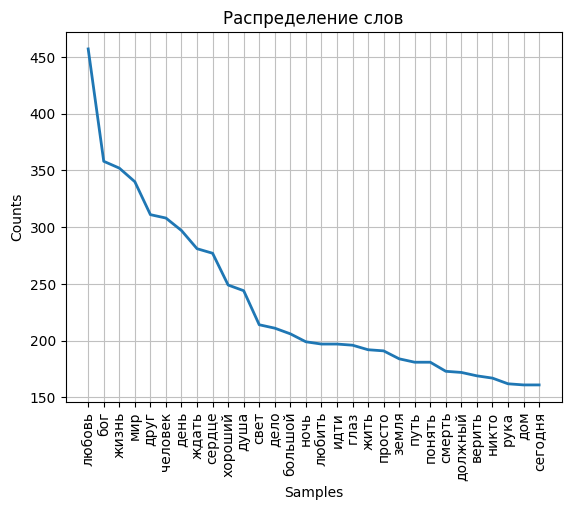

In [ ]:
word_frequencies.plot(30, title='Распределение слов')

In [ ]:
corpus = [text for text in df_texts['Леммы склеенные']]

In [ ]:
for i in corpus:
    print(i[:100])

внимание житель остров айсвилль собрать приятный место именно морг айсвилля находиться тело ева суно
профессор профессор хей-хо-хей отозваться профессор хей-хо-хей сбиться путь наверняка снова где-то п
родиться слепой тьма упасть высота невредимый ловкий сметь гордиться гулять джелли уметь джелли твор
блаженный любой приехать мерано мерано рано утром магнит манить ванна здешний климат просто рай райс
мёд месье спешить цирк луиджи пинелли сегодня ежедневно смертельный трюк зрелище крепкий нерв сенсац
улица погибший город обветшалый цирк театр лицо жизнь кружиться кольцо корчиться голод сузить рамка 
лунный путь лежать седьмой дом юпитер заслонять марс планета мир согласие звезда любить восходить во
дорогой мамочка завтра отправляться пансион миссис рид тётя опекунша уверять хороший правда кузина э
блаженный нищий дух нищий душа познать смысл праведный жизнь блаженный чистый сердце милостивый блаж
пассажир задача занять хороший хороший место ехать ехать долгий далёкий туда куда-то куда-т

# TF-IDF

Можно ли получить что-то внятное на этом корпусе с помощью TF-IDF?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(corpus) #полученные tf-idf вектора 

In [ ]:
text_vector = pd.DataFrame(columns = tfidf_vectorizer.get_feature_names_out(), data = X.toarray()) 
text_vector 

addio     adieu      agne      amen       and      anna     baden  \
0   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.00000  0.000000  0.013831  0.000000  0.000000  0.000000  0.000000   
2   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.00000  0.015656  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.00000  0.000000  0.000000  0.026182  0.000000  0.000000  0.000000   
16  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.00000  0.000000  0.000000  0.000000  0.000000  0.012366  0.012366   
18  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
24  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
26  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
27  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
28  0.00000  0.000000  0.000000  0.000000  0.035801  0.000000  0.000000   
29  0.01088  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

      basta  bastardo     belua  ...  яхонтовый   ячейка   ячневый    ящерка  \
0   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
1   0.00000   0.00000  0.013831  ...   0.000000  0.00000  0.000000  0.000000   
2   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
3   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
4   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
5   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
6   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
7   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
8   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
9   0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
10  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
11  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
12  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
13  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
14  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
15  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
16  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
17  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.012366  0.012366   
18  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   
19  0.00000   0.00000  0.000000  ...   0.000000  0.00000  0.000000  0.000000   


In [ ]:
# соберем инфу по всем текстам

lemmas = list(text_vector.columns)
tf_idf_info = []

for i in range(0,len(text_vector)):
    tf_idf = text_vector.iloc[i].tolist() 
    lemmas_tf_idf = list(zip(lemmas, tf_idf))

    sorted_tf_idf = sorted(lemmas_tf_idf, key=lambda x: x[1], reverse = 'True')
    tf_idf_info.append(sorted_tf_idf)
    print(sorted_tf_idf[:10])

[('ева', 0.45977291995472774), ('бо', 0.4113642496160748), ('купон', 0.38674893774174535), ('материк', 0.16114539072572723), ('май', 0.15719690813026924), ('айса', 0.1396593386289636), ('остров', 0.12978563713121583), ('лёд', 0.12847487711076344), ('айсвилль', 0.11817328653219998), ('инспектор', 0.11817328653219998)]
[('сара', 0.35961057446921724), ('профессор', 0.2833075932209567), ('чеснок', 0.17264844204328933), ('хей', 0.14648883234764817), ('альфред', 0.1383117594112374), ('кролка', 0.11064940752898993), ('бал', 0.10843829651162669), ('мрак', 0.10365716445023618), ('душа', 0.10099522553200196), ('ночной', 0.1008899238252206)]
[('кот', 0.6349750231830048), ('джелли', 0.39330873254555154), ('макавитя', 0.26969741660266394), ('кошка', 0.13493219242638854), ('рам', 0.10113653122599899), ('таггер', 0.10113653122599899), ('там', 0.10113653122599899), ('билли', 0.10019385045025575), ('гроултайгер', 0.08989913886755466), ('даль', 0.0801550803602046)]
[('мерано', 0.30451846146906264), ('иг

Видно, что большинство ключевых слов, отличающих текст от других, составляют **именованные сущности**. В первую очередь это имена персонажей или же слова, которыми их обозначают - то есть, по сути, их синонимы в данном контексте (принц, цыган, барон, профессор...)

Здесь нет ничего интересного

#### Именованные сущности также захватили и биграммы:

In [ ]:
# биграммы
for i in df_texts['Токены без стопслов']:
    bigramms = nltk.bigrams(i)
    print(Counter(bigramms).most_common(20))

#trigramms = nltk.trigrams(df_texts['Токены без стопслов'][1])
#print(Counter(trigramms).most_common(10))

[(('белый', 'купон'), 11), (('бо', 'бо'), 6), (('айс', 'айс'), 6), (('пару', 'месяцев'), 4), (('месяцев', 'назад'), 4), (('постой', 'постой'), 4), (('господин', 'мэр'), 4), (('друг', 'другом'), 3), (('мужским', 'голосом'), 3), (('подругу', 'ищу'), 3), (('айсвилль', 'пару'), 3), (('купон', 'купон'), 3), (('ночь', 'купону'), 3), (('купон', 'заветный'), 3), (('заветный', 'белый'), 3), (('купон', 'белый'), 3), (('ева', 'тебе'), 3), (('лю', 'ева'), 3), (('приехала', 'остров'), 2), (('тело', 'морг'), 2)]
[(('культуры', 'создана'), 8), (('фон', 'кролок'), 8), (('мрак', 'ночной'), 8), (('час', 'настал'), 6), (('создана', 'культуры'), 4), (('господин', 'профессор'), 4), (('вниз', 'вниз'), 4), (('профессор', 'профессор'), 3), (('профессор', 'хей-хо-хей'), 3), (('профессор', 'абронзиус'), 3), (('мага', 'бога'), 3), (('забыто', 'имя'), 3), (('вечная', 'жизнь'), 3), (('лети', 'мной'), 3), (('господин', 'куколь'), 3), (('натура', 'прогресса'), 3), (('прогресса', 'культуры'), 3), (('слава', 'богу'), 

### Косинусная близость: насколько тексты либретто похожи

In [ ]:
tfidf_matrix = cosine_similarity(X)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

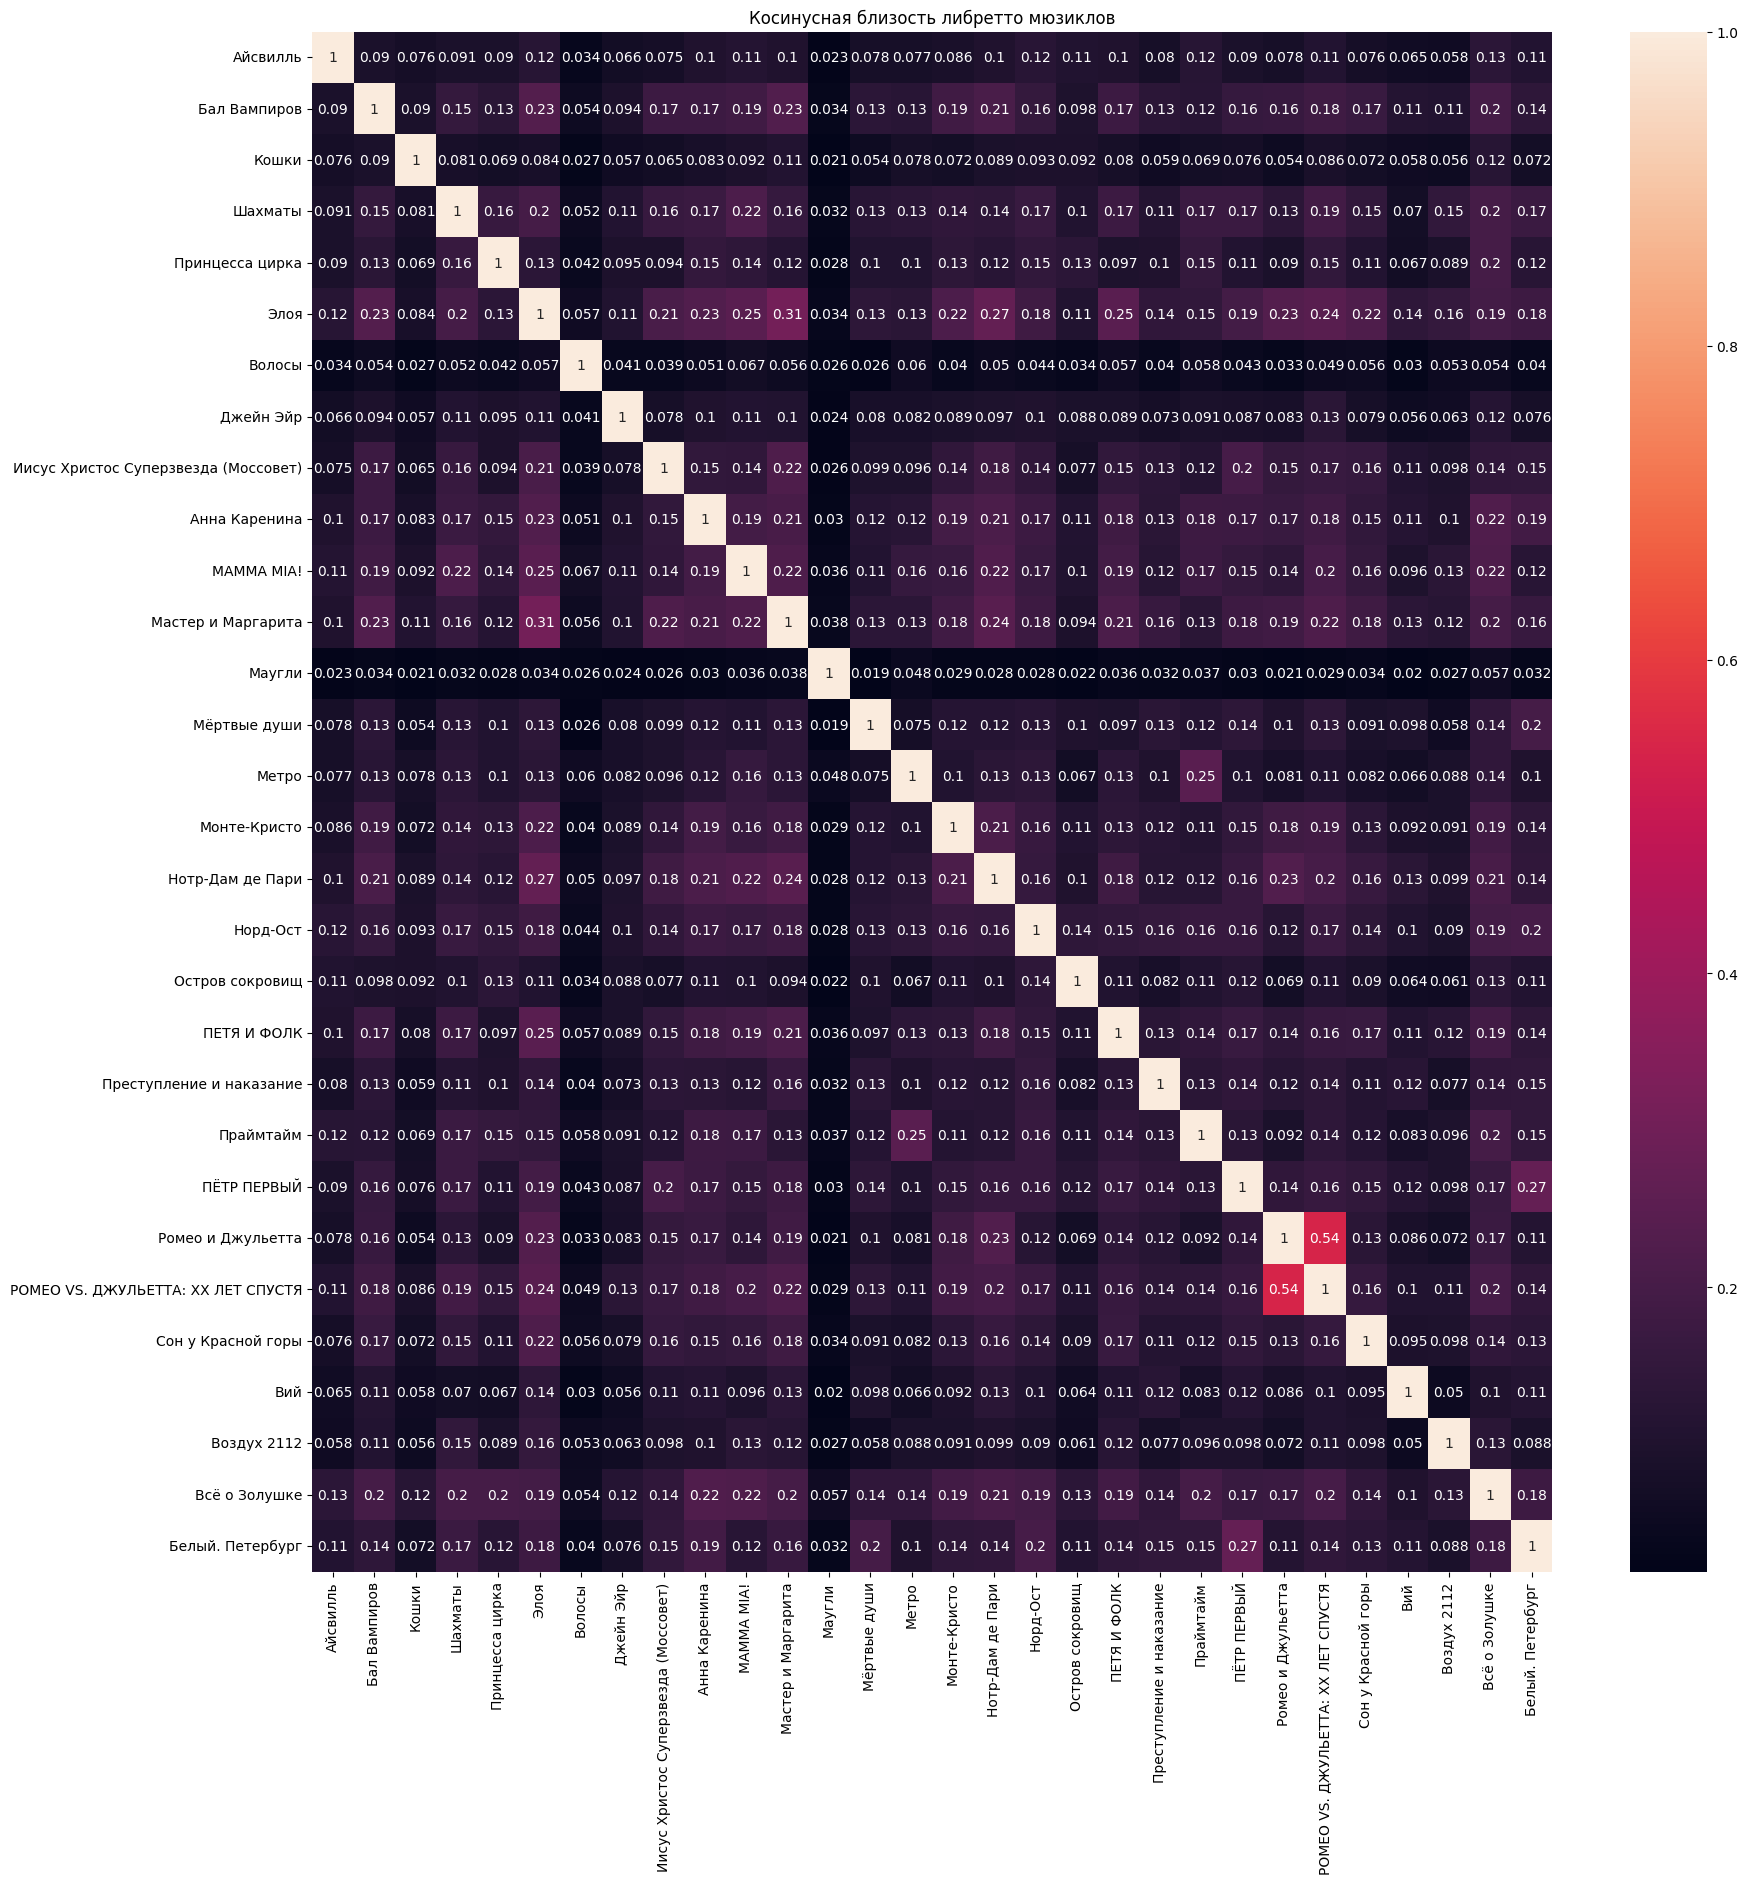

In [ ]:
# Строим heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(tfidf_matrix, annot=True, xticklabels=df_texts['Название'], yticklabels=df_texts['Название'])
plt.title("Косинусная близость либретто мюзиклов")
plt.savefig('cos_matrix.png', format='png', dpi=500)
plt.show()

# fmt='.2f' - округление

In [ ]:
# выведем пары текстов с наибольшей косинусной близостью
threshold = 0.24 # наш порог
cosines_all = []
results = []

# количество текстов всего
num_texts = tfidf_matrix.shape[0]

# Проходимся по матрице
for i in range(num_texts):
    for j in range(i + 1, num_texts):
        # Проверяем, выше ли значение, чем порог
        similarity = tfidf_matrix[i][j]
        text1 = df_texts.loc[i, 'Название'].upper()
        text2 = df_texts.loc[j, 'Название'].upper()
        cosines_all.append((text1, text2, similarity))

        if similarity > threshold:
            results.append((text1, text2, similarity))    
            # print(f"('{text1.upper()}' и '{text2.upper()}'): {tfidf_matrix[i][j]}")

results.sort(key=lambda x: x[2], reverse=True)
for res in results:
    print(f'{round(res[2], 5)} - косинусная близость {res[0]} и {res[1]}')

0.54257 - косинусная близость РОМЕО И ДЖУЛЬЕТТА и РОМЕО VS. ДЖУЛЬЕТТА: XX ЛЕТ СПУСТЯ
0.30709 - косинусная близость ЭЛОЯ и МАСТЕР И МАРГАРИТА
0.27332 - косинусная близость ПËТР ПЕРВЫЙ и БЕЛЫЙ. ПЕТЕРБУРГ
0.26868 - косинусная близость ЭЛОЯ и НОТР-ДАМ ДЕ ПАРИ
0.24766 - косинусная близость МЕТРО и ПРАЙМТАЙМ
0.24691 - косинусная близость ЭЛОЯ и ПЕТЯ И ФОЛК
0.24638 - косинусная близость ЭЛОЯ и MAMMA MIA!
0.24461 - косинусная близость ЭЛОЯ и РОМЕО VS. ДЖУЛЬЕТТА: XX ЛЕТ СПУСТЯ
0.24274 - косинусная близость МАСТЕР И МАРГАРИТА и НОТР-ДАМ ДЕ ПАРИ


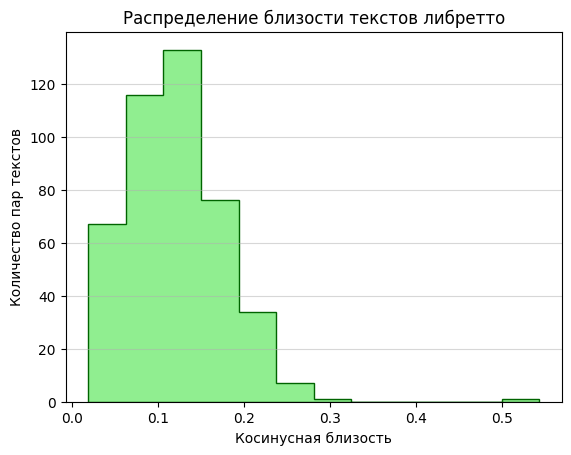

In [ ]:
# построим гистограмму близостей текстов 
cosine_similarities = [res[2] for res in cosines_all]

plt.hist(cosine_similarities, bins=12, color='lightgreen', edgecolor='darkgreen', histtype='stepfilled' )
plt.title('Распределение близости текстов либретто')
plt.xlabel('Косинусная близость')
plt.ylabel('Количество пар текстов')
plt.grid(axis='y', alpha=0.5)
plt.savefig('cosine.png', format='png', dpi=300)
plt.show()

В общем, ничего путного, попробуем что-нибудь еще посчитать

## Оценка лексического разнообразия: TTR и MA TTR

### moving average ttr

In [ ]:
# найдем ттр по тексту без стопслов
ttr_data = []

for i in df_texts.index:
    name = df_texts.loc[i, 'Название']    
    words_count = len(df_texts.loc[i, 'Токены обычные'])
    lemmas_count = len(set(df_texts.loc[i, 'Леммы обычные']))

    ttr = lemmas_count / words_count
    ttr_data.append((name, words_count, lemmas_count, ttr))
    


In [ ]:
assessment = pd.DataFrame(ttr_data, columns= ['Название', 'N токенов', 'N уникальных лемм', 'TTR'])

In [ ]:
# %pip install lexical-diversity

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from lexical_diversity import lex_div as ld

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\lexical_diversity\lex_div.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
assessment['MA TTR'] = df_texts['Токены обычные'].apply(ld.mattr)
assessment['MA TTR (леммы)'] = df_texts['Леммы'].apply(ld.mattr)
assessment['MA TTR (леммы со стопсловами)'] = df_texts['Леммы обычные'].apply(ld.mattr)
#window_length=100

In [ ]:
assessment

Название  N токенов  N уникальных лемм  \
0                               Айсвилль       5616               1654   
1                           Бал Вампиров       6231               1874   
2                                  Кошки       4434               1636   
3                                Шахматы       5777               1534   
4                        Принцесса цирка      10282               2070   
5                                   Элоя       6003               1475   
6                                 Волосы       1407                709   
7                              Джейн Эйр       3698               1219   
8   Иисус Христос Суперзвезда (Моссовет)       4056               1169   
9                          Анна Каренина       3931               1157   
10                            MAMMA MIA!       2429                740   
11                    Мастер и Маргарита       4034               1481   
12                                Маугли       1207                570   
13                          Мёртвые души       5556               1964   
14                                 Метро       2029                789   
15                          Монте-Кристо       5608               1427   
16                      Нотр-Дам де Пари       5269               1320   
17                              Норд-Ост       7985               2294   
18                       Остров сокровищ       7499               2052   
19                           ПЕТЯ И ФОЛК       2781               1004   
20              Преступление и наказание       3062               1087   
21                             Праймтайм       8373               2102   
22                           ПËТР ПЕРВЫЙ       7295               2149   
23                     Ромео и Джульетта       5790               1422   
24    РОМЕО VS. ДЖУЛЬЕТТА: XX ЛЕТ СПУСТЯ       7178               1854   
25                    Сон у Красной горы       4342               1347   
26                                   Вий       5416               1594   
27                           Воздух 2112       1496                553   
28                         Всё о Золушке       8676               2075   
29                      Белый. Петербург       8078               2638   

         TTR    MA TTR  MA TTR (леммы)  MA TTR (леммы со стопсловами)  
0   0.294516  0.863413        0.877921                       0.819641  
1   0.300754  0.863986        0.901561                       0.820450  
2   0.368967  0.856078        0.899166                       0.826878  
3   0.265536  0.874654        0.922497                       0.826201  
4   0.201323  0.870605        0.880896                       0.824300  
5   0.245710  0.827608        0.871410                       0.775724  
6   0.503909  0.870692        0.874671                       0.835228  
7   0.329638  0.871044        0.902343                       0.822532  
8   0.288215  0.831270        0.875627                       0.782511  
9   0.294327  0.786425        0.814414                       0.743854  
10  0.304652  0.839529        0.866393                       0.771655  
11  0.367129  0.897882        0.933068                       0.858334  
12  0.472245  0.869585        0.862733                       0.826511  
13  0.353492  0.861812        0.887866                       0.831589  
14  0.388862  0.867626        0.872245                       0.819768  
15  0.254458  0.791142        0.822596                       0.750232  
16  0.250522  0.806640        0.839977                       0.751897  
17  0.287289  0.836696        0.895567                       0.803637  
18  0.273636  0.880174        0.895674                       0.836290  
19  0.361021  0.858690        0.891599                       0.813697  
20  0.354997  0.814935        0.833404                       0.772134  
21  0.251045  0.832571        0.864807                       0.788698  
22  0.294585  0.879434        0.908357                       0.837047  
23  0.245

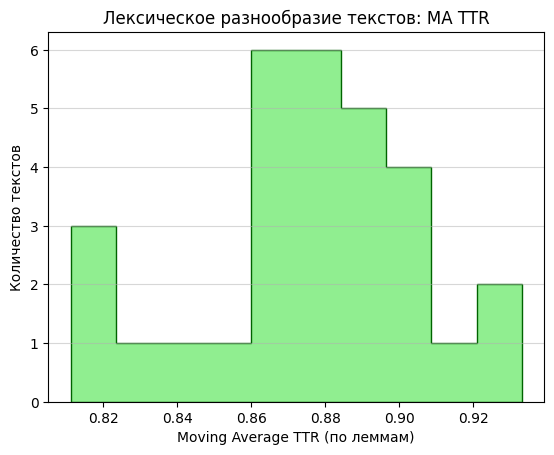

In [ ]:
# построим гистограмму
ma_ttrs = [ma for ma in assessment['MA TTR (леммы)']]

plt.hist(ma_ttrs, bins=10, color='lightgreen', edgecolor='darkgreen', histtype='stepfilled' )
plt.title('Лексическое разнообразие текстов: MA TTR')
plt.xlabel('Moving Average TTR (по леммам)')
plt.ylabel('Количество текстов')
plt.grid(axis='y', alpha=0.5)
plt.savefig('mattr.png', format='png', dpi=300)
plt.show()

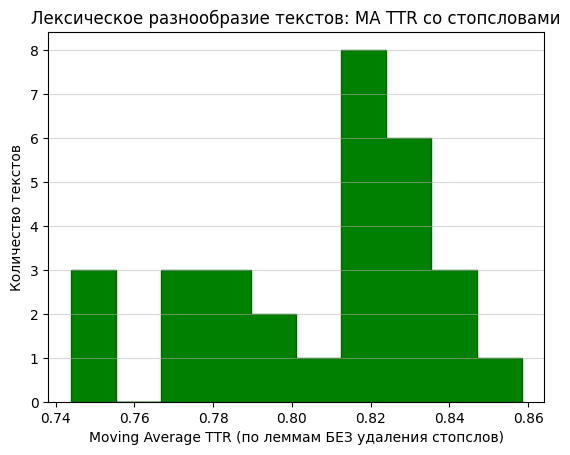

In [ ]:
# построим гистограмму
ma_stops = [ma for ma in assessment['MA TTR (леммы со стопсловами)']]

plt.hist(ma_stops, bins=10, color='green', edgecolor='darkgreen', histtype='stepfilled' )
plt.title('Лексическое разнообразие текстов: MA TTR со стопсловами')
plt.xlabel('Moving Average TTR (по леммам БЕЗ удаления стопслов)')
plt.ylabel('Количество текстов')
plt.grid(axis='y', alpha=0.5)
plt.savefig('ma_ttr_stop.png', format='png', dpi=300)
plt.show()

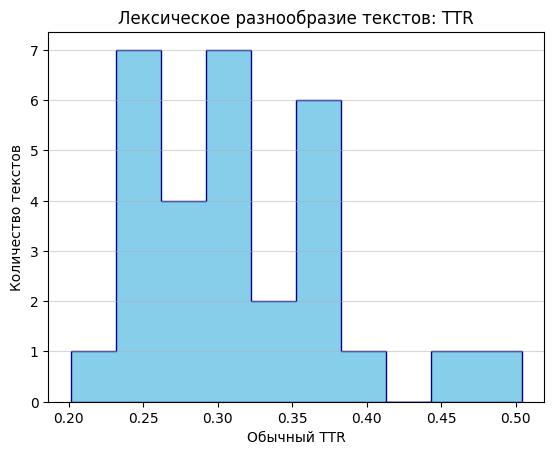

In [ ]:
# построим гистограмму
ttrs = [ttr for ttr in assessment['TTR']]

plt.hist(ttrs, bins=10, color='skyblue', edgecolor='darkblue', histtype='stepfilled' )
plt.title('Лексическое разнообразие текстов: TTR')
plt.xlabel('Обычный TTR')
plt.ylabel('Количество текстов')
plt.grid(axis='y', alpha=0.5)
plt.savefig('ttr.png', format='png', dpi=300)
plt.show()


### Динамика изменения Moving Average TTR по мере продвижения по тексту
Графики для всех спектаклей изация ТТРов

In [ ]:
def calculate_moving_average_ttr(text, window_size=100, step=10):
    '''Считает динамический MA TTR, продвигаясь по тексту и фиксируя значения каждого окна'''
    words = text
    ttr_values = []
    positions = []

    for i in range(0, len(words) - window_size + 1, step): # расчет TTR для каждого окна
        window = words[i:i + window_size]
        window_text = ' '.join(window)
        ttr = ld.ttr(window_text)
        ttr_values.append(ttr)
        positions.append(i / len(words))  # позиция в тексте в процентах

    return positions, ttr_values

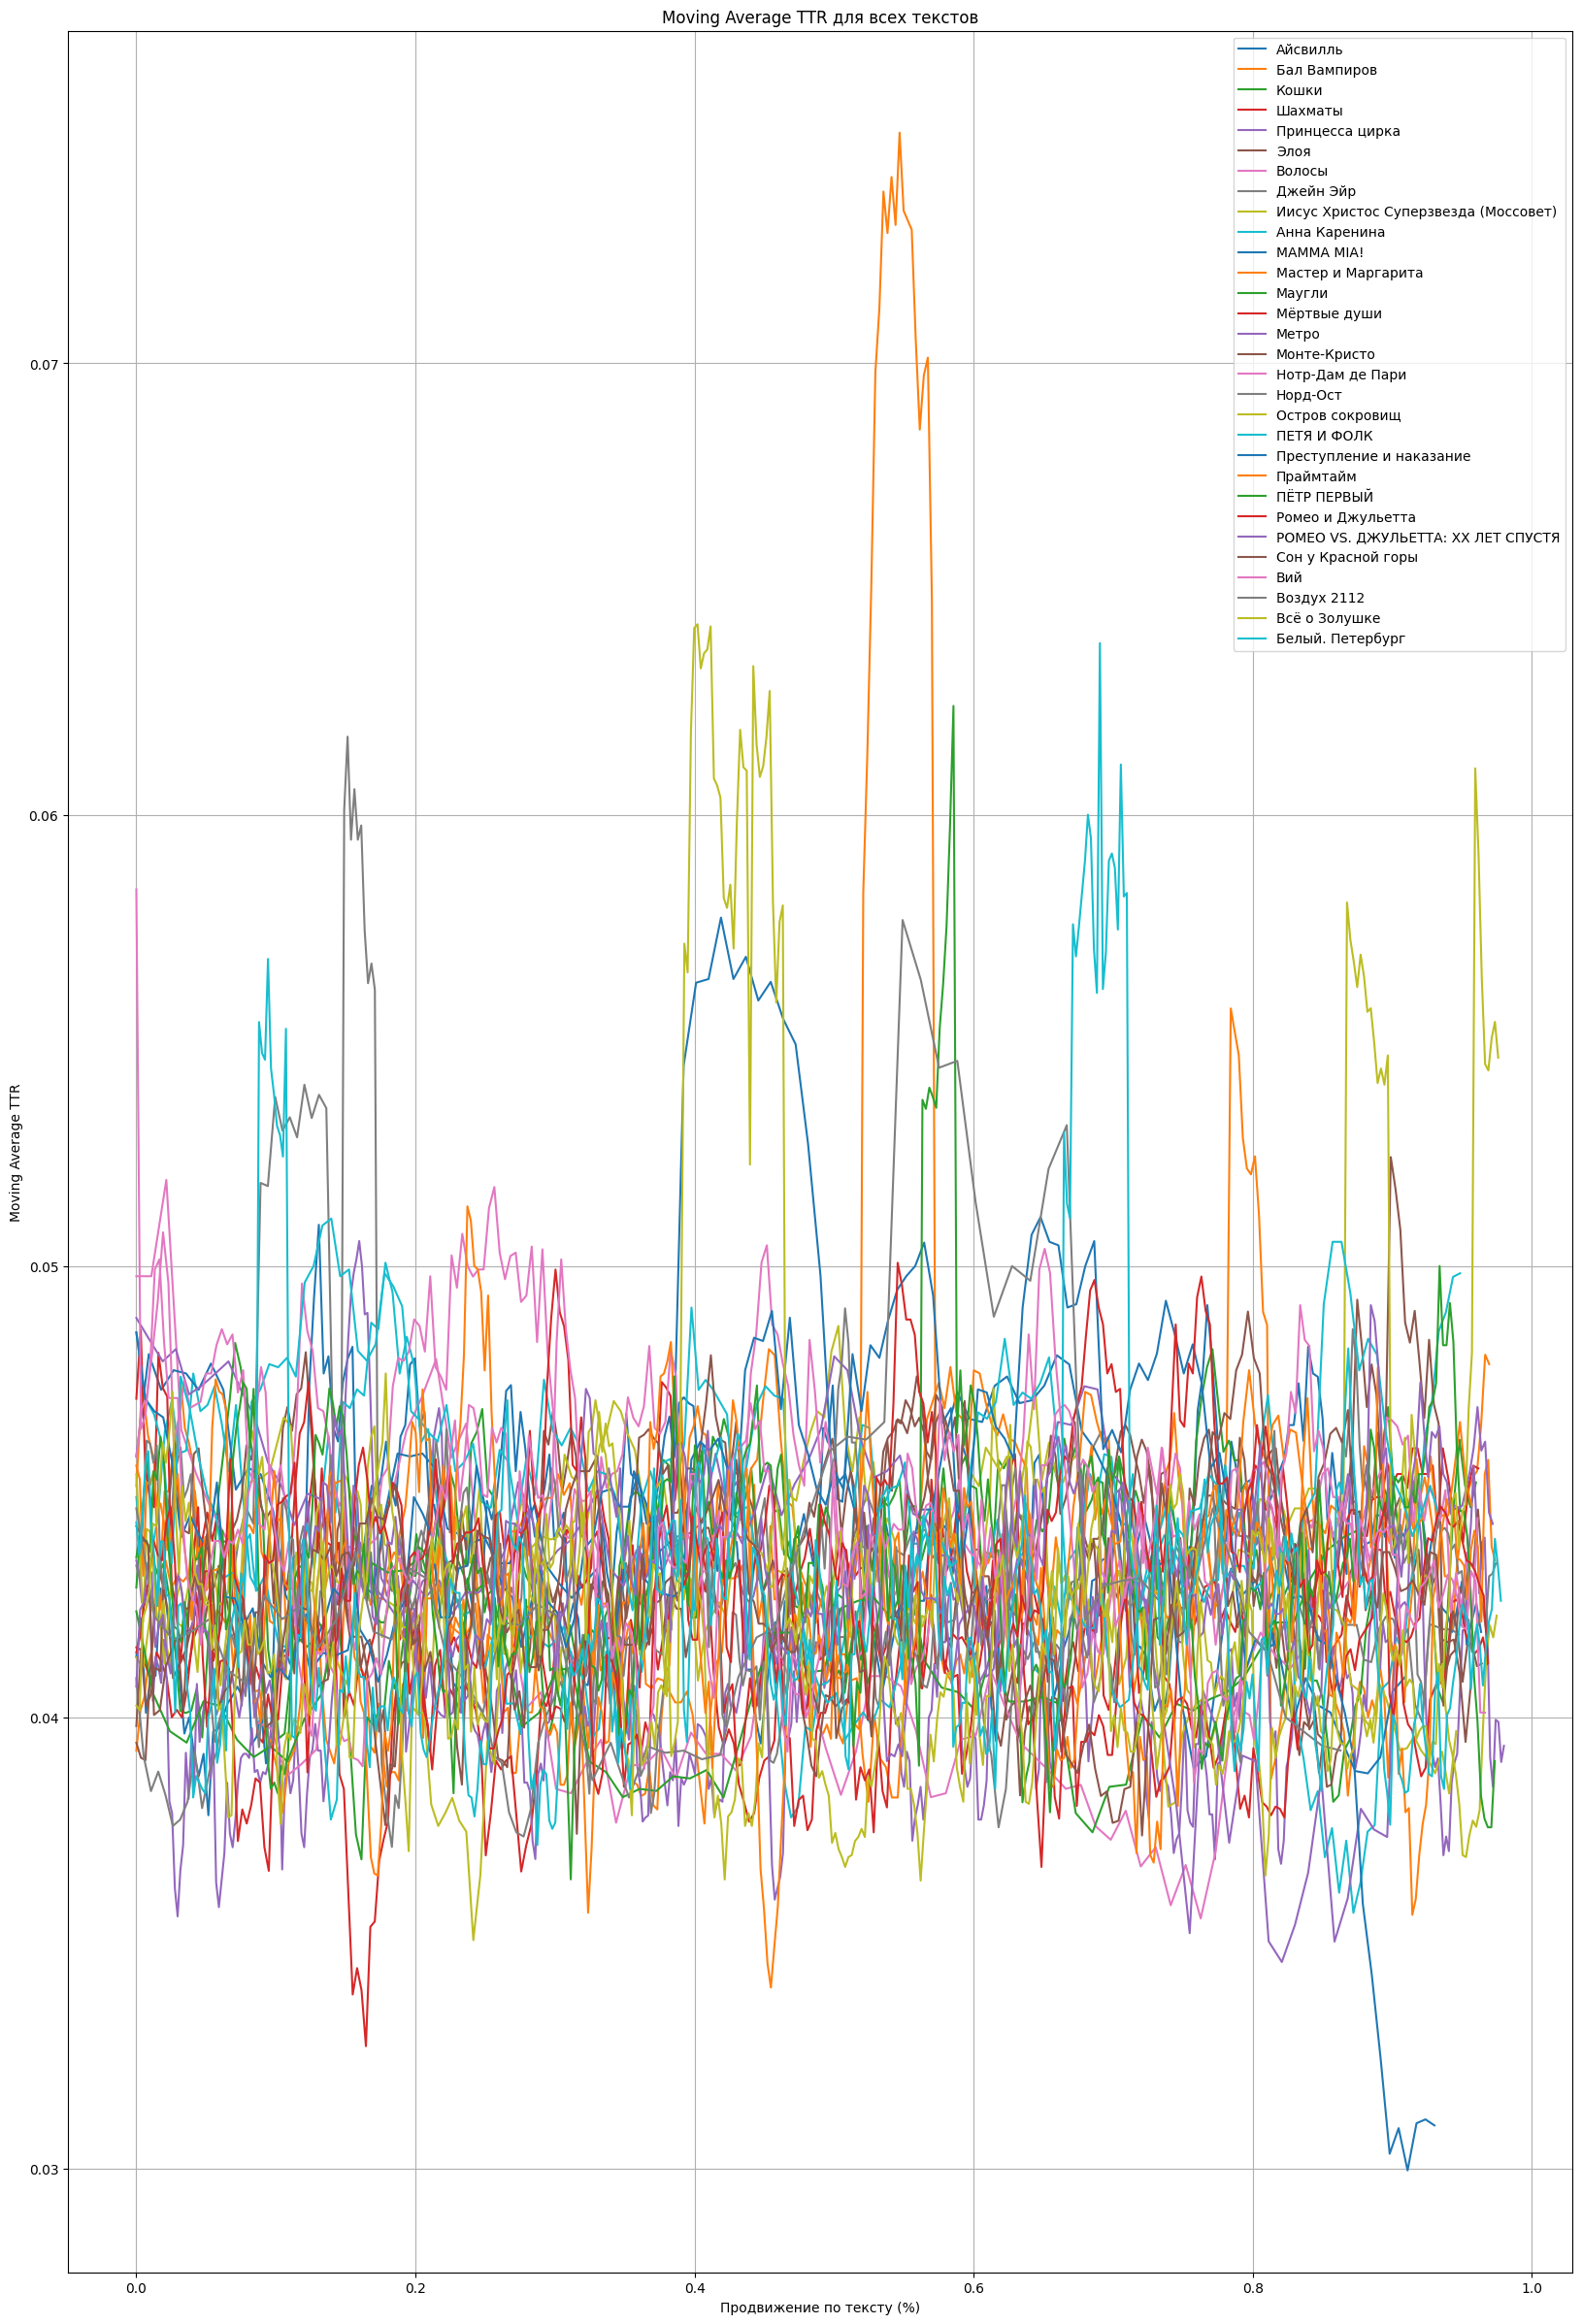

In [ ]:
#построим график

plt.figure(figsize=(20, 30))

for index, row in df_texts.iterrows():
    positions, ttr_values = calculate_moving_average_ttr(row['Леммы'])
    plt.plot(positions, ttr_values, label=row['Название'])

plt.title('Moving Average TTR для всех текстов')
plt.xlabel('Продвижение по тексту (%)')
plt.ylabel('Moving Average TTR')
plt.legend()
plt.grid(True)
plt.savefig('ma_ttr_stop.png', format='png', dpi=400)
plt.show()

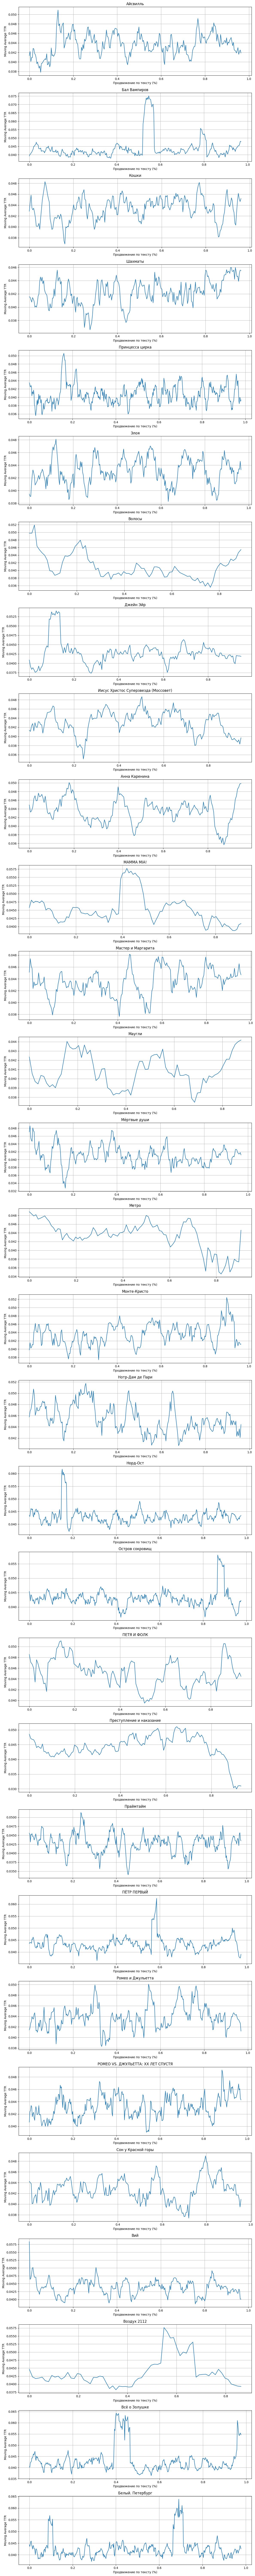

In [ ]:
# сколько текстов всего
num_texts = len(df_texts)

# фигура, на которой будут располагаться графики
fig, axes = plt.subplots(num_texts, 1, figsize=(12, 4 * num_texts))

for i, (index, row) in enumerate(df_texts.iterrows()):
    positions, ttr_values = calculate_moving_average_ttr(row['Леммы'])
    ax = axes[i]
    ax.plot(positions, ttr_values)
    ax.set_title(row['Название'])
    ax.set_xlabel('Продвижение по тексту (%)')
    ax.set_ylabel('Moving Average TTR')
    ax.grid(True)

plt.tight_layout()
plt.savefig('mattrs_all.png', format='png', dpi=400)
plt.show()

### Сведения о частях речи в текстах

In [ ]:
# сбор данных о частях речи

pos_data = []
# все части речи из возможных
pos = ['NOUN', 'VERB', 'INFN', 'PRTF', 'PRTS', 'ADJF', 'ADJS', 'COMP', 'ADVB', 'NPRO', 'PRCL', 'PREP', 'GRND', 'NUMR',  'CONJ', 'PRED', 'INTJ', None]


for i in df_texts.index:
    name = df_texts.loc[i, 'Название']    
    tokens_list = df_texts.loc[i, 'Токены обычные']
    words_count = len(tokens_list)

    text_pos_data = [] # данные о частях речи
    
    for token in tokens_list:
        word_parsed = morph.parse(token)[0]
        text_pos_data.append(word_parsed.tag.POS)
    
    pos_counts = FreqDist(text_pos_data) # сколько токенов каждой из частей речи есть
    
    pos_to_df = [] # выстраиваем теги в нужном порядке и заполням нули, если есть
    for p in pos:
        if p in pos_counts.keys():
            pos_to_df.append(pos_counts[p])
        else:
            pos_to_df.append(0)
    #pos_tuple = (tuple(pos) for pos in pos_to_df)
    pos_data.append((name, words_count) + (tuple(pos_to_df))) # 


In [ ]:
pos_df = pd.DataFrame(pos_data, columns = ['Название', 'Всего токенов'] + pos)

In [ ]:
pos_df.insert(2, 'Доля существительных', pos_df['NOUN'] / pos_df['Всего токенов'])

In [ ]:
pos_df.insert(3, 'Доля глаголов', pos_df['VERB'] / pos_df['Всего токенов'])

In [ ]:
pos_df.insert(4, 'Доля глаголов (вкл. инфинитивы)', (pos_df['VERB'] + pos_df['INFN']) / pos_df['Всего токенов'])

In [ ]:
pos_df.insert(5, 'Доля прилагательных', (pos_df['ADJF'] + pos_df['ADJS']) / pos_df['Всего токенов'])
pos_df.insert(6, 'Доля наречий', pos_df['ADVB'] / pos_df['Всего токенов'])

In [ ]:
pos_df

Название  Всего токенов  Доля существительных  \
0                               Айсвилль           5616              0.223647   
1                           Бал Вампиров           6231              0.262558   
2                                  Кошки           4434              0.293866   
3                                Шахматы           5777              0.206335   
4                        Принцесса цирка          10282              0.209784   
5                                   Элоя           6003              0.255206   
6                                 Волосы           1407              0.373845   
7                              Джейн Эйр           3698              0.248783   
8   Иисус Христос Суперзвезда (Моссовет)           4056              0.226824   
9                          Анна Каренина           3931              0.222844   
10                            MAMMA MIA!           2429              0.193084   
11                    Мастер и Маргарита           4034              0.317551   
12                                Маугли           1207              0.396023   
13                          Мёртвые души           5556              0.279338   
14                                 Метро           2029              0.269591   
15                          Монте-Кристо           5608              0.256776   
16                      Нотр-Дам де Пари           5269              0.256595   
17                              Норд-Ост           7985              0.226299   
18                       Остров сокровищ           7499              0.270569   
19                           ПЕТЯ И ФОЛК           2781              0.289824   
20              Преступление и наказание           3062              0.252123   
21                             Праймтайм           8373              0.224054   
22                           ПËТР ПЕРВЫЙ           7295              0.277039   
23                     Ромео и Джульетта           5790              0.318998   
24    РОМЕО VS. ДЖУЛЬЕТТА: XX ЛЕТ СПУСТЯ           7178              0.255921   
25                    Сон у Красной горы           4342              0.276370   
26                                   Вий           5416              0.268279   
27                           Воздух 2112           1496              0.243316   
28                         Всё о Золушке           8676              0.206201   
29                      Белый. Петербург           8078              0.294008   

    Доля глаголов  Доля глаголов (вкл. инфинитивы)  Доля прилагательных  \
0        0.148860                         0.171474             0.105413   
1        0.125823                         0.153105             0.132082   
2        0.128101                         0.153811             0.118854   
3        0.117189                         0.166003             0.123074   
4        0.124198                         0.163490             0.108928   
5        0.142262                         0.177078             0.108279   
6        0.116560                         0.133618             0.132907   
7        0.131963                         0.170633             0.094375   
8        0.143491                         0.178994             0.112673   
9        0.116764                         0.150598             0.107352   
10       0.152326                         0.191437             0.097983   
11       0.131383                         0.160635             0.119236   
12       0.149959                         0.180613             0.082850   
13       0.133369                         0.165227             0.111591   
14       0.135042                         0.158206             0.104978   
15       0.136769                         0.161198             0.110735   
16       0.123743                         0.150313             0.127349   
17       0.138134                         0.170820             0.097433   
18       0.132284                         0.166822             0.105481   
19       0.132686   